In [18]:
import pandas as pd
# never forget: https://www.lfd.uci.edu/~gohlke/pythonlibs/#fiona
import geopandas as gpd
import requests
pd.set_option('display.max_columns',None)

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from collections import defaultdict
from copy import deepcopy
import pickle

## Purpose

This notebook reads FAF5 regional data and US Census county data and generates an artifact mapping:

 FAF5 zone ID -> dict((STATEFP,COUNTYFP): % area coverage)

### Get FAF5 geographic data

In [2]:
target_path = '../data/raw/faf5_regions.zip'
faf5_regions = gpd.read_file(target_path)

In [4]:
assert len(faf5_regions['faf_zone'].unique())==len(faf5_regions)

### Get county geographic data

In [3]:
target_path = '../data/raw/us_county_shp_files.zip'
county_gdf = gpd.read_file(target_path)

In [5]:
# area computation requires consistent CRS representation
county_gdf = county_gdf.to_crs(faf5_regions.crs)
county_gdf['area'] = county_gdf.area

In [32]:
# county shp file data is unique at STATEFP, COUNTYFP composite key
assert len(county_gdf[['STATEFP','COUNTYFP']].drop_duplicates())==len(county_gdf)

In [35]:
# construct a map of this dataframe's index to (STATEFP,COUNTYFP)
county_idx_map = {row.Index: (row.STATEFP,row.COUNTYFP) for row in county_gdf.itertuples()}

### Compute which counties are part of which FAF5 region (and what percentage of their area)

In [7]:
%%time
INTERSECTION_AREA_TOLERANCE_PERCENT = .01
faf_zone_to_county = dict()
for row in faf5_regions.itertuples():

    # return just the "overlap" of the FAF5 region with county data
    county_intersection = county_gdf.intersection(row.geometry)
    nonzero_county_intersection = county_intersection[~county_intersection.is_empty]

    # get the full county data and compute the percentage of county overlap by area, ignoring anything less than the tolerance
    full_intersected_counties = county_gdf.loc[nonzero_county_intersection.index]
    intersected_counties_relative_area = nonzero_county_intersection.area/full_intersected_counties.area
    tol_adjusted_county_intersection = intersected_counties_relative_area.loc[np.where(intersected_counties_relative_area>INTERSECTION_AREA_TOLERANCE_PERCENT,True,False)]
    
    faf_zone_to_county[row.faf_zone] = np.round(tol_adjusted_county_intersection,2).to_dict()

CPU times: total: 1min 8s
Wall time: 1min 8s


In [11]:
# compute a map that links faf_zone_ids to counties
# compute a map that tabulates the percentage of a county's area that's covered by a FAF zone
county_coverage = defaultdict(float)
county_id_to_faf_zone_id = defaultdict(list)
for faf_zone_id, val in faf_zone_to_county.items():
    for county_id, coverage in val.items():
        county_coverage[county_id] += coverage
        county_id_to_faf_zone_id[county_id].append(faf_zone_id)

In [12]:
# get the county keys that are not totally covered
not_totally_covered_county_ids = [k for k,covered_area_pct in county_coverage.items() if covered_area_pct < 1]
unusual_faf_region_keys = [k for k,v in faf_zone_to_county.items() if any([county_key in not_totally_covered_county_ids for county_key in v.keys()])]

# if a county's area has not been totally covered AND there's more than one FAF zone that covers this county...we have a problem
assert {k:len(v) for k,v in county_id_to_faf_zone_id.items() if k in not_totally_covered_county_ids and len(v) > 1}==dict()

# as long as there is only 1 FAF region covering a "problem" county, we assign *all* of the county's area to be fully part of the FAF region
faf_zone_to_county_canonical = deepcopy(faf_zone_to_county)
for faf_zone, county_dict in faf_zone_to_county_canonical.items():
    for some_uncovered_county_id in not_totally_covered_county_ids:
        if some_uncovered_county_id in county_dict.keys():
            county_dict[some_uncovered_county_id] = 1.0

county_coverage_canonical = defaultdict(float)
for faf_zone_id, val in faf_zone_to_county_canonical.items():
    for county_id, coverage in val.items():
        county_coverage_canonical[county_id] += coverage

# ensure that our canonical linkage of FAF zone IDs to county areas is complete
assert min(county_coverage_canonical.values())==1.0

### Serialize the results

In [41]:
# we relied on the index of the county geographic data to identify each county row - but, for usage with census data,
# we serialize using the (STATEFP, COUNTYFP) code
faf_zone_id_to_state_county_id = dict()
for faf_zone_id, county_data in faf_zone_to_county_canonical.items():
    faf_zone_id_to_state_county_id[faf_zone_id] = {county_idx_map.get(k):v for k,v in county_data.items()}

# structure of this file is a dictionary with 
# key = FAF zone ID
# value = dict of (STATEFP, COUNTYFP): percentage of area of the county covered by the FAF zone
with open('../data/transformed/faf_zone_id_to_state_county_id.pickle','wb') as fp:
    pickle.dump(faf_zone_id_to_state_county_id, fp)

## Investigative / ad hoc from this point down

In [42]:
# confirm that there are indeed counties that are split amoung faf zones
for faf_zone_id, val in faf_zone_to_county_canonical.items():
    for county_id, covered in val.items():
        if covered < 1:
            print(faf_zone_id, county_id, covered)

091 1394 0.85
091 1395 0.06
091 1396 0.05
091 1397 0.08
223 1747 0.02
092 1395 0.94
092 1397 0.92
341 2333 0.02
363 2333 0.98
050 2188 0.99
099 1394 0.15
099 1396 0.95
229 1747 0.98
280 2188 0.01
519 748 0.01
511 748 0.99


In [13]:
m=faf5_regions.loc[faf5_regions['faf_zone'].isin(unusual_faf_region_keys)].explore()
county_gdf.iloc[not_totally_covered_county_ids].explore(m=m,color='red',style_kwds={'opacity':0.1},tooltip=False)

In [14]:
INTERSECTION_AREA_TOLERANCE_PERCENT = .01

some_faf5_region = faf5_regions.sample(1)
county_intersection = county_gdf.intersection(some_faf5_region.geometry.values[0])
nonzero_county_intersection = county_intersection[~county_intersection.is_empty]
full_intersected_counties = county_gdf.loc[nonzero_county_intersection.index]
intersected_counties_relative_area = nonzero_county_intersection.area/full_intersected_counties.area
tol_adjusted_county_intersection = intersected_counties_relative_area.loc[np.where(intersected_counties_relative_area>INTERSECTION_AREA_TOLERANCE_PERCENT,True,False)]
tol_adjusted_full_intersected_counties = county_gdf.loc[tol_adjusted_county_intersection.index]

In [16]:
m=some_faf5_region.explore(color='green',style_kwds={'opacity':0.3})
tol_adjusted_full_intersected_counties.explore(m=m,color='yellow',style_kwds={'opacity':0.1},tooltip=False)

<Axes: >

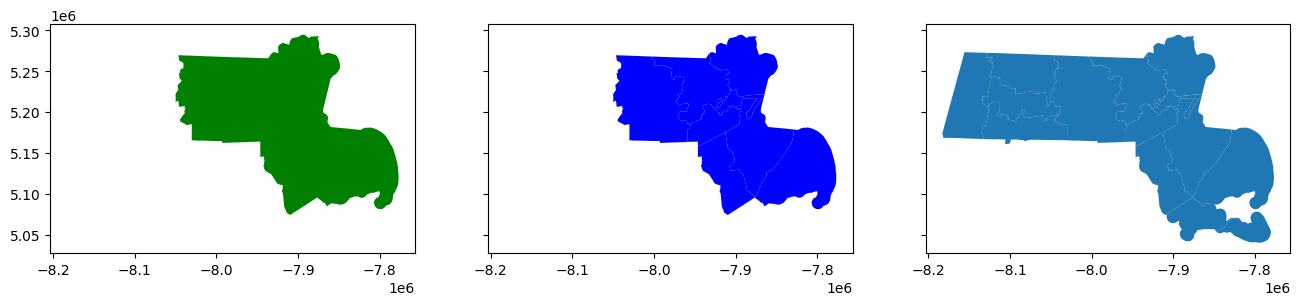

In [17]:
fig,axs=plt.subplots(ncols=3,figsize=(16,8),sharey=True,sharex=True)
some_faf5_region.plot(ax=axs[0],color='green')

tol_adjusted_full_intersected_counties.plot(ax=axs[1],color='blue')
majority_state_fp_code = tol_adjusted_full_intersected_counties['STATEFP'].value_counts().index[0]
county_gdf.loc[county_gdf['STATEFP']==majority_state_fp_code].plot(ax=axs[2])